In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    LSTM, Dense, Dropout,
    LayerNormalization,
    GlobalAveragePooling1D,
    MultiHeadAttention
)


2025-12-25 11:04:34.928939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766660675.075187      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766660675.119311      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766660675.476800      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766660675.476864      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766660675.476867      55 computation_placer.cc:177] computation placer alr

In [2]:
DATA_PATH = "/kaggle/input/nasa-battery-cycle-level-dataset/battery_cycle_level_dataset_CLEAN_FINAL.csv"

df = pd.read_csv(DATA_PATH)
print(df.head())
print(df.shape)


  battery_id  cycle   voltage  temperature  capacity       soh  rul
0      B0005      1  3.532781    32.536891  1.861976  1.000000  167
1      B0005      2  3.542968    32.643595  1.851862  0.994568  166
2      B0005      3  3.553056    32.522526  1.840808  0.988631  165
3      B0005      4  3.545849    32.492083  1.850058  0.993599  164
4      B0005      5  3.544456    32.368612  1.849432  0.993263  163
(1415, 7)


In [3]:
print("Batteries:", df['battery_id'].nunique())
print("Total cycles:", len(df))

df[['voltage','temperature','capacity','soh','rul']].describe()


Batteries: 34
Total cycles: 1415


,voltage,temperature,capacity,soh,rul
count,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000
mean,3.420612,26.589773,1.501191,0.849014,54.175972
std,0.166460,13.196045,0.316995,0.119219,43.709204
min,2.530010,7.684550,0.520105,0.604449,0.000000
25%,3.387078,9.555186,1.321640,0.750777,16.500000
50%,3.452596,31.139259,1.504115,0.850350,43.000000
75%,3.507450,32.753400,1.709022,0.961174,86.000000
max,3.753027,54.997372,2.498996,1.048527,167.000000


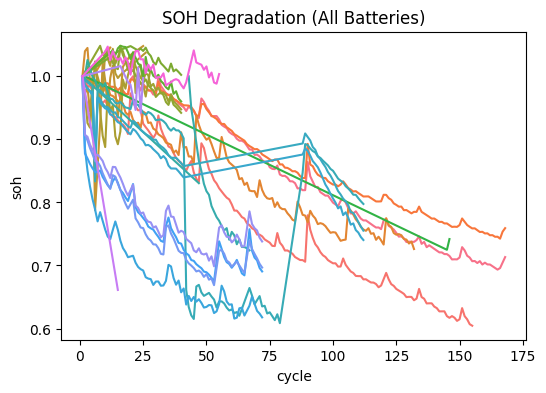

In [4]:
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x='cycle', y='soh', hue='battery_id', legend=False)
plt.title("SOH Degradation (All Batteries)")
plt.show()


In [5]:
FEATURES = ['voltage', 'temperature', 'capacity']
TARGET = 'soh'
WINDOW_SIZE = 20


In [6]:
scaler_X = MinMaxScaler()
df[FEATURES] = scaler_X.fit_transform(df[FEATURES])


In [7]:
def create_sequences(df, features, target, window):
    X, y = [], []
    for _, bdf in df.groupby('battery_id'):
        bdf = bdf.sort_values('cycle')
        feat = bdf[features].values
        targ = bdf[target].values
        for i in range(len(bdf) - window):
            X.append(feat[i:i+window])
            y.append(targ[i+window])
    return np.array(X), np.array(y)

X_soh, y_soh = create_sequences(df, FEATURES, TARGET, WINDOW_SIZE)

X_train, X_test, y_train, y_test = train_test_split(
    X_soh, y_soh, test_size=0.2, random_state=42
)

print("SOH input shape:", X_train.shape)


SOH input shape: (787, 20, 3)


In [8]:
inputs = Input(shape=(WINDOW_SIZE, len(FEATURES)))

# ---- CNN BLOCK (Local Patterns)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# ---- LSTM BLOCK (Temporal Degradation)
x = LSTM(64, return_sequences=True)(x)
x = LayerNormalization()(x)

# ---- MULTI-HEAD ATTENTION
attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = tf.keras.layers.Add()([x, attn])
x = LayerNormalization()(x)

# ---- AGGREGATION
x = GlobalAveragePooling1D()(x)

# ---- REGRESSION HEAD
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)

model_soh = Model(inputs, outputs)

model_soh.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_soh.summary()


I0000 00:00:1766660687.322262      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 18, 64)    │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 9, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 7, 32)     │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 3, 32)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 64)     │     24,832 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 3, 64)     │        128 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 64)     │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,233 (262.63 KB)

 Trainable params: 67,233 (262.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model_soh.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


I0000 00:00:1766660692.320616     134 cuda_dnn.cc:529] Loaded cuDNN version 91002


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.6831 - mae: 0.6136 - val_loss: 0.0087 - val_mae: 0.0763
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0696 - mae: 0.2098 - val_loss: 0.0094 - val_mae: 0.0801
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0468 - mae: 0.1700 - val_loss: 0.0060 - val_mae: 0.0628
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0496 - mae: 0.1783 - val_loss: 0.0106 - val_mae: 0.0857
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0515 - mae: 0.1731 - val_loss: 0.0237 - val_mae: 0.1387
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0436 - mae: 0.1651 - val_loss: 0.0081 - val_mae: 0.0766
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0423 - mae: 0.1599 - val_loss: 0.0081 - val_mae: 0.0720
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0467 - mae: 0.1713 - val_loss: 0.0048 - val_mae: 0.0552
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0395 - mae: 0.

In [10]:
y_pred = model_soh.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("CNN–LSTM–Attention SOH MAE:", mae)
print("CNN–LSTM–Attention SOH RMSE:", rmse)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
CNN–LSTM–Attention SOH MAE: 0.07599667314556267
CNN–LSTM–Attention SOH RMSE: 0.08403018665721382


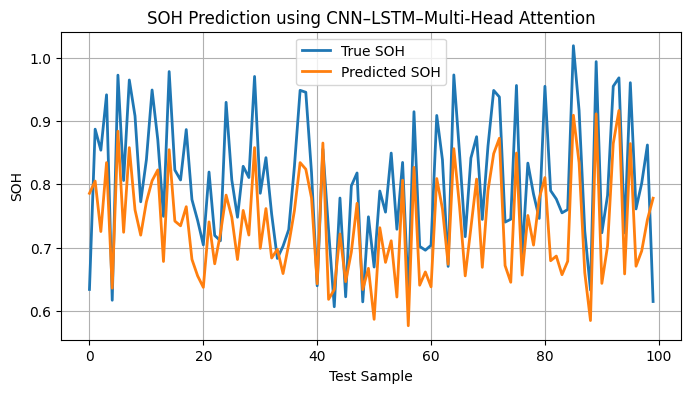

In [11]:
plt.figure(figsize=(8,4))
plt.plot(y_test[:100], label="True SOH", linewidth=2)
plt.plot(y_pred[:100], label="Predicted SOH", linewidth=2)
plt.xlabel("Test Sample")
plt.ylabel("SOH")
plt.title("SOH Prediction using CNN–LSTM–Multi-Head Attention")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model_soh.save("/kaggle/working/cnn_lstm_attention_soh_model.keras")


In [13]:
import joblib
joblib.dump(scaler_X, "/kaggle/working/feature_scaler_soh.pkl")


['/kaggle/working/feature_scaler_soh.pkl']

# **RUL** 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D,
    LSTM, Dense, Dropout,
    LayerNormalization,
    GlobalAveragePooling1D,
    MultiHeadAttention
)


In [15]:
DATA_PATH = "/kaggle/input/nasa-battery-cycle-level-dataset/battery_cycle_level_dataset_CLEAN_FINAL.csv"
df = pd.read_csv(DATA_PATH)

FEATURES = ['voltage', 'temperature', 'capacity']
WINDOW_SIZE = 20


In [16]:
scaler_X = MinMaxScaler()
df[FEATURES] = scaler_X.fit_transform(df[FEATURES])

scaler_rul = MinMaxScaler()
df[['rul']] = scaler_rul.fit_transform(df[['rul']])


In [17]:
def create_sequences(df, features, target, window):
    X, y = [], []
    for _, bdf in df.groupby('battery_id'):
        bdf = bdf.sort_values('cycle')
        f = bdf[features].values
        t = bdf[target].values
        for i in range(len(bdf) - window):
            X.append(f[i:i+window])
            y.append(t[i+window])
    return np.array(X), np.array(y)

X_rul, y_rul = create_sequences(df, FEATURES, 'rul', WINDOW_SIZE)

X_train, X_test, y_train, y_test = train_test_split(
    X_rul, y_rul, test_size=0.2, random_state=42
)


In [18]:
inputs = Input(shape=(WINDOW_SIZE, len(FEATURES)))

# --- CNN BLOCK (Local Degradation Patterns)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)

# --- RNN BLOCK (Temporal Degradation)
x = LSTM(64, return_sequences=True)(x)
x = LayerNormalization()(x)

# --- MULTI-HEAD ATTENTION (Important Cycles)
attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = tf.keras.layers.Add()([x, attn])
x = LayerNormalization()(x)

# --- AGGREGATION
x = GlobalAveragePooling1D()(x)

# --- REGRESSION HEAD
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)  # needed for MC Dropout
outputs = Dense(1)(x)

model_rul = Model(inputs, outputs)

model_rul.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_rul.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 18, 64)    │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 9, 64)     │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 7, 32)     │      6,176 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 3, 32)     │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 3, 64)     │     24,832 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ lstm_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 64)     │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 3, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,233 (262.63 KB)

 Trainable params: 67,233 (262.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model_rul.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3261 - mae: 0.4292 - val_loss: 0.0388 - val_mae: 0.1626
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0443 - mae: 0.1649 - val_loss: 0.0348 - val_mae: 0.1573
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0381 - mae: 0.1565 - val_loss: 0.0272 - val_mae: 0.1371
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0340 - mae: 0.1435 - val_loss: 0.0173 - val_mae: 0.1064
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0298 - mae: 0.1323 - val_loss: 0.0126 - val_mae: 0.0873
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0207 - mae: 0.1064 - val_loss: 0.0113 - val_mae: 0.0826
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0254 - mae: 0.1195 - val_loss: 0.0179 - val_mae: 0.1090
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mae: 0.1150 - val_loss: 0.0112 - val_mae: 0.0782
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.023

In [20]:
y_pred = model_rul.predict(X_test)

y_pred_inv = scaler_rul.inverse_transform(y_pred)
y_test_inv = scaler_rul.inverse_transform(y_test.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("CNN-RNN-Attention RUL MAE (cycles):", mae)
print("CNN-RNN-Attention RUL RMSE (cycles):", rmse)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
CNN-RNN-Attention RUL MAE (cycles): 12.766643015866352
CNN-RNN-Attention RUL RMSE (cycles): 16.96857145747519


In [21]:
def mc_dropout_predict(model, X, n_samples=100):
    preds = np.array([
        model(X, training=True).numpy().flatten()
        for _ in range(n_samples)
    ])
    return preds.mean(axis=0), preds.std(axis=0)

mean_pred, std_pred = mc_dropout_predict(model_rul, X_test)


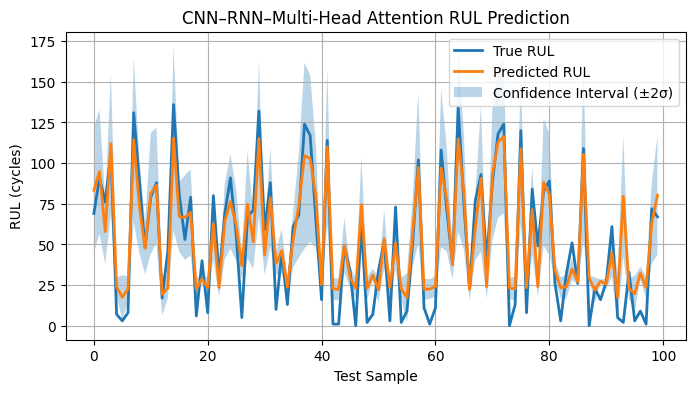

In [22]:
mean_inv = scaler_rul.inverse_transform(mean_pred.reshape(-1,1))
upper = scaler_rul.inverse_transform((mean_pred + 2*std_pred).reshape(-1,1))
lower = scaler_rul.inverse_transform((mean_pred - 2*std_pred).reshape(-1,1))

plt.figure(figsize=(8,4))
plt.plot(y_test_inv[:100], label="True RUL", linewidth=2)
plt.plot(mean_inv[:100], label="Predicted RUL", linewidth=2)
plt.fill_between(
    range(100),
    lower[:100].flatten(),
    upper[:100].flatten(),
    alpha=0.3,
    label="Confidence Interval (±2σ)"
)
plt.xlabel("Test Sample")
plt.ylabel("RUL (cycles)")
plt.title("CNN–RNN–Multi-Head Attention RUL Prediction")
plt.legend()
plt.grid(True)
plt.show()


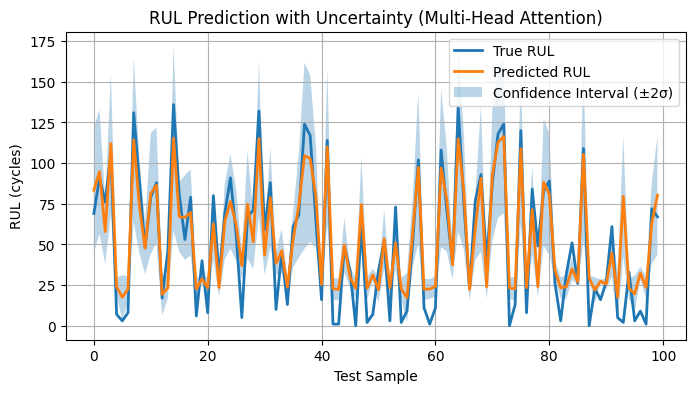

In [23]:
plt.figure(figsize=(8,4))

plt.plot(y_test_inv[:100], label="True RUL", linewidth=2)
plt.plot(
    scaler_rul.inverse_transform(mean_pred[:100].reshape(-1,1)),
    label="Predicted RUL",
    linewidth=2
)

upper = scaler_rul.inverse_transform((mean_pred[:100] + 2*std_pred[:100]).reshape(-1,1))
lower = scaler_rul.inverse_transform((mean_pred[:100] - 2*std_pred[:100]).reshape(-1,1))

plt.fill_between(
    range(100),
    lower.flatten(),
    upper.flatten(),
    alpha=0.3,
    label="Confidence Interval (±2σ)"
)

plt.xlabel("Test Sample")
plt.ylabel("RUL (cycles)")
plt.title("RUL Prediction with Uncertainty (Multi-Head Attention)")
plt.legend()
plt.grid(True)
plt.show()


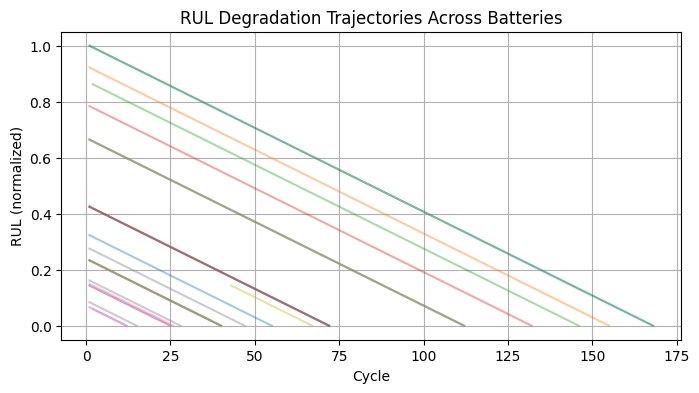

In [24]:
plt.figure(figsize=(8,4))
for bid, bdf in df.groupby('battery_id'):
    plt.plot(bdf['cycle'], bdf['rul'], alpha=0.4)

plt.xlabel("Cycle")
plt.ylabel("RUL (normalized)")
plt.title("RUL Degradation Trajectories Across Batteries")
plt.grid(True)
plt.show()


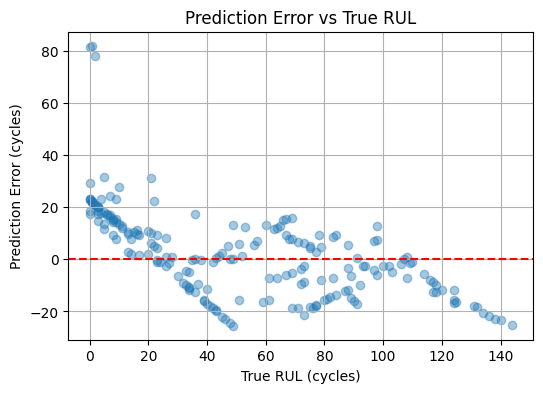

In [27]:
errors = y_pred_inv.flatten() - y_test_inv.flatten()

plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, errors, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True RUL (cycles)")
plt.ylabel("Prediction Error (cycles)")
plt.title("Prediction Error vs True RUL")
plt.grid(True)
plt.show()


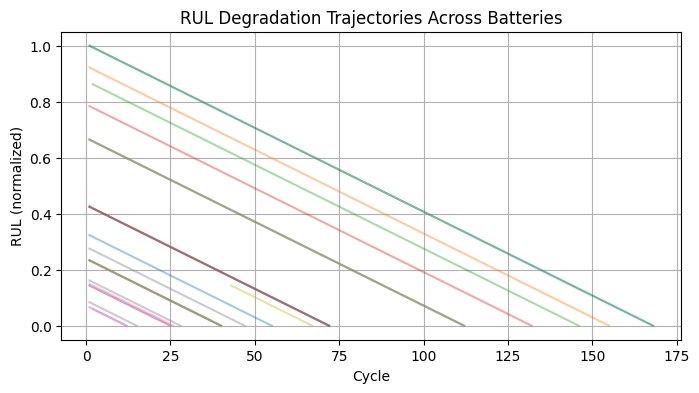

In [28]:
plt.figure(figsize=(8,4))
for bid, bdf in df.groupby('battery_id'):
    plt.plot(bdf['cycle'], bdf['rul'], alpha=0.4)

plt.xlabel("Cycle")
plt.ylabel("RUL (normalized)")
plt.title("RUL Degradation Trajectories Across Batteries")
plt.grid(True)
plt.show()


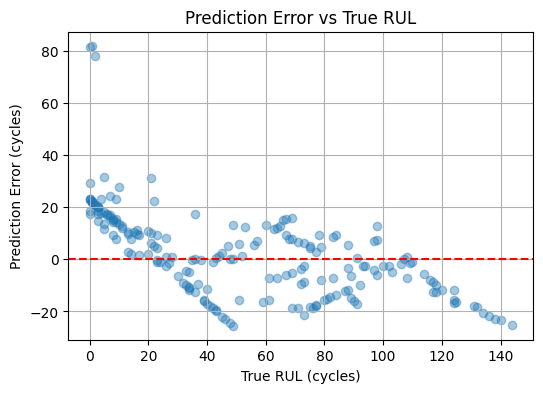

In [31]:
errors = y_pred_inv.flatten() - y_test_inv.flatten()

plt.figure(figsize=(6,4))
plt.scatter(y_test_inv, errors, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True RUL (cycles)")
plt.ylabel("Prediction Error (cycles)")
plt.title("Prediction Error vs True RUL")
plt.grid(True)
plt.show()


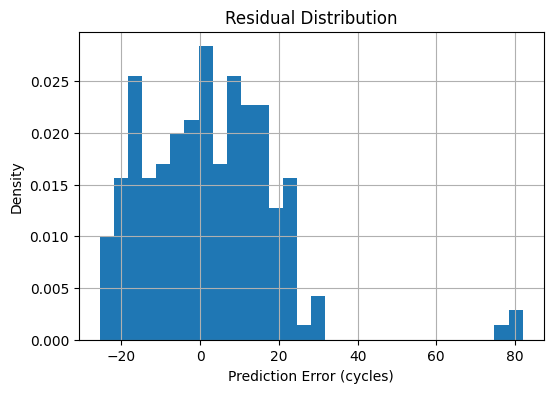

In [32]:
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, density=True)
plt.xlabel("Prediction Error (cycles)")
plt.ylabel("Density")
plt.title("Residual Distribution")
plt.grid(True)
plt.show()


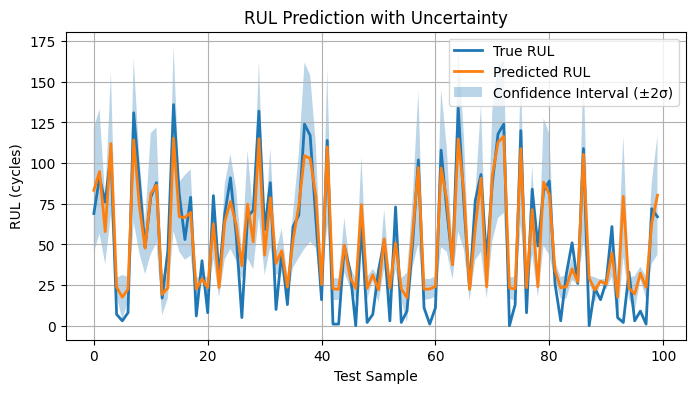

In [33]:
plt.figure(figsize=(8,4))

plt.plot(y_test_inv[:100], label="True RUL", linewidth=2)
plt.plot(mean_inv[:100], label="Predicted RUL", linewidth=2)

plt.fill_between(
    range(100),
    lower[:100].flatten(),
    upper[:100].flatten(),
    alpha=0.3,
    label="Confidence Interval (±2σ)"
)

plt.xlabel("Test Sample")
plt.ylabel("RUL (cycles)")
plt.title("RUL Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


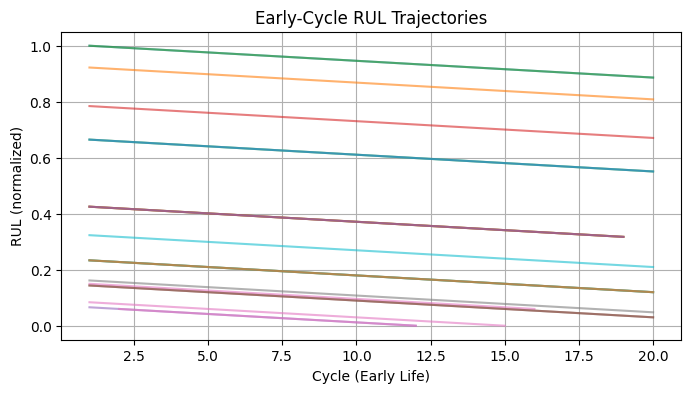

In [34]:
early_mask = df['cycle'] <= 20
early_df = df[early_mask]

plt.figure(figsize=(8,4))
for bid, bdf in early_df.groupby('battery_id'):
    plt.plot(bdf['cycle'], bdf['rul'], alpha=0.6)

plt.xlabel("Cycle (Early Life)")
plt.ylabel("RUL (normalized)")
plt.title("Early-Cycle RUL Trajectories")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


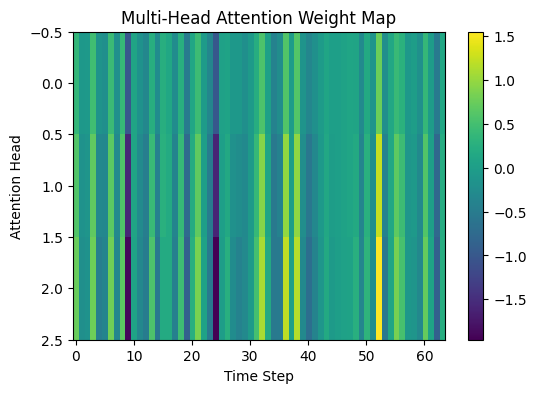

In [35]:
# Extract attention scores (last batch)
attention_layer = model_rul.layers[6]  # MultiHeadAttention layer
attention_model = Model(
    inputs=model_rul.input,
    outputs=attention_layer.output
)

attn_output = attention_model.predict(X_test[:1])

plt.figure(figsize=(6,4))
plt.imshow(attn_output[0], aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel("Time Step")
plt.ylabel("Attention Head")
plt.title("Multi-Head Attention Weight Map")
plt.show()


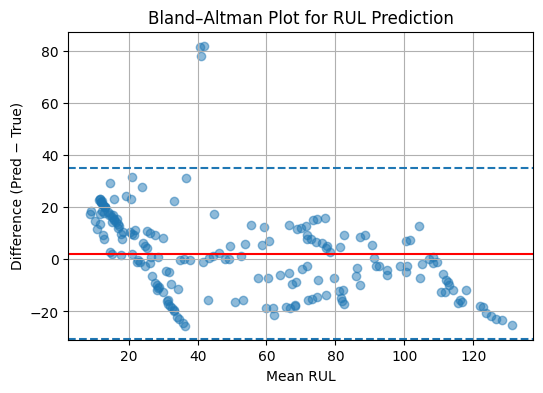

In [36]:
mean_vals = (y_test_inv.flatten() + y_pred_inv.flatten()) / 2
diff_vals = y_pred_inv.flatten() - y_test_inv.flatten()

plt.figure(figsize=(6,4))
plt.scatter(mean_vals, diff_vals, alpha=0.5)
plt.axhline(np.mean(diff_vals), color='r')
plt.axhline(np.mean(diff_vals) + 1.96*np.std(diff_vals), linestyle='--')
plt.axhline(np.mean(diff_vals) - 1.96*np.std(diff_vals), linestyle='--')
plt.xlabel("Mean RUL")
plt.ylabel("Difference (Pred − True)")
plt.title("Bland–Altman Plot for RUL Prediction")
plt.grid(True)
plt.show()


In [38]:
import numpy as np

y_test_inv = np.asarray(y_test_inv).reshape(-1)
y_pred_inv = np.asarray(y_pred_inv).reshape(-1)


In [39]:
max_val = np.max(y_test_inv)


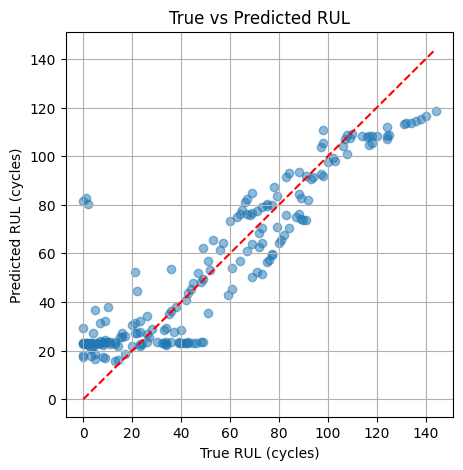

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
plt.plot([0, max_val], [0, max_val], 'r--')
plt.xlabel("True RUL (cycles)")
plt.ylabel("Predicted RUL (cycles)")
plt.title("True vs Predicted RUL")
plt.grid(True)
plt.show()
